# MODELO 3 - CGAN para generar una imagen del CIFAR-100 a pedido del usuario

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.15.0


- Importo las librerias neceasarias

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import cifar100
from keras.preprocessing import image
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout, BatchNormalization, Embedding, Concatenate
import matplotlib.pyplot as plt
import numpy as np
import time
import os
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [2]:
devices = tf.config.list_physical_devices('GPU')
print(len(devices))

0


- Cargo el dataset

In [3]:
tags = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle',
    'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle',
    'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard',
    'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain',
    'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree',
    'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket',
    'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider',
    'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor',
    'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]

(X_train, y_train), (X_test, y_test) = cifar100.load_data(label_mode='fine')

img_size = X_train.shape[1] # tamaño de las imagenes (cuadradas)

X_train = (X_train - 127.5) / 127.5
X_test = (X_test - 127.5) / 127.5 # los valores se escalan para estar en el rango [-1, 1]

print(img_size)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

32
(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


- Ploteo de un número random del dataset junto con su etiqueta

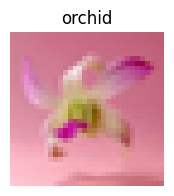

In [4]:
plt.figure(figsize=(2,2))
idx = np.random.randint(0,len(X_train))
img = image.array_to_img(X_train[idx], scale=True)
plt.imshow(img)
plt.axis('off')
plt.title(tags[y_train[idx][0]])
plt.show()

# Construcción del generador

In [5]:
def build_generator(n_class, noise_dim, img_size):

    in_label = Input(shape=(1,), name='Label_Input')
    li = Embedding(n_class, 50, name='Embedding')(in_label) # Capa de embedding para las etiquetas
    img_size_in = img_size // 4
    n_nodes = img_size_in * img_size_in
    li = Dense(n_nodes, name='Label_Dense')(li) # Capa densa para las etiquetas
    li = Reshape((img_size_in, img_size_in, 1), name='Label_Reshape')(li) # Cambio la forma de la capa

    in_lat = Input(shape=(noise_dim,), name='Latent_Input') # Capa de entrada de ruido
    n_nodes = 256 * img_size_in * img_size_in
    gen = Dense(n_nodes, name='Generator_Dense')(in_lat) # Capa densa para el ruido
    gen = Reshape((img_size_in, img_size_in, 256), name='Generator_Reshape')(gen) # Cambio la forma de la capa
    #---------------------------------------------------------------------------------#
    merge = Concatenate(name='Concatenate')([gen, li]) # Concateno las capas
    #---------------------------------------------------------------------------------#
    gen = Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', name='Conv2DTranspose_1')(merge)  # 16x16x256
    gen = BatchNormalization(name='Generator_BatchNormalization_1')(gen)
    gen = LeakyReLU(alpha=0.2, name='Generator_LeakyReLU_1')(gen)
    #---------------------------------------------------------------------------------#
    gen = Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', name='Conv2DTranspose_2')(gen)  # 32x32x128
    gen = BatchNormalization(name='Generator_BatchNormalization_2')(gen)
    gen = LeakyReLU(alpha=0.2, name='Generator_LeakyReLU_2')(gen)
    #---------------------------------------------------------------------------------#
    out_layer = Conv2DTranspose(3, (5, 5), strides=(1,1), activation='tanh', padding='same', name='Output_Conv2DTranspose_3')(gen)  # 32x32x3
    #---------------------------------------------------------------------------------#

    generator = Model([in_lat, in_label], out_layer, name='Generator')
    plot_model(generator, to_file='/content/drive/MyDrive/Lembo/generator_structure_m3_cifar100.png', show_shapes=True, show_layer_names=True)

    return generator

# Construcción del discriminador

In [6]:
def build_discriminator(n_class, noise_dim, img_size):

    in_label = Input(shape=(1,), name='Label_Input')
    li = Embedding(n_class, 50, name='Embedding')(in_label)
    n_nodes = img_size * img_size
    li = Dense(n_nodes, name='Label_Dense')(li)
    li = Reshape((img_size, img_size, 1), name='Label_Reshape')(li)

    in_image = Input(shape=(img_size, img_size, 3), name='Image_Input')
    in_image = Dropout(0.75, name='Dropout')(in_image)
    merge = Concatenate(name='Concatenate')([in_image, li])
    #---------------------------------------------------------------------------------#
    fe = Conv2D(32, (5, 5), strides=(2, 2), padding='same', name='Conv2D_1')(merge) # 16x16x32
    fe = LeakyReLU(alpha=0.2, name='LeakyReLU_1')(fe)
    #---------------------------------------------------------------------------------#
    fe = Conv2D(64, (5, 5), strides=(2, 2), padding='same', name='Conv2D_2')(fe) # 8x8x64
    fe = BatchNormalization(name='Generator_BatchNormalization_1')(fe)
    fe = LeakyReLU(alpha=0.2, name='LeakyReLU_2')(fe)
    #---------------------------------------------------------------------------------#
    fe = Conv2D(128, (5, 5), strides=(2, 2), padding='same', name='Conv2D_3')(fe) # 4x4x128
    fe = BatchNormalization(name='Generator_BatchNormalization_2')(fe)
    fe = LeakyReLU(alpha=0.2, name='LeakyReLU_3')(fe)
    #---------------------------------------------------------------------------------#
    fe = Conv2D(256, (5, 5), strides=(2, 2), padding='same', name='Conv2D_4')(fe) # 2x2x256
    #---------------------------------------------------------------------------------#
    fe = Flatten(name='Flatten')(fe)
    out_layer = Dense(1, activation='sigmoid', name='Output_Dense')(fe)
    #---------------------------------------------------------------------------------#

    discriminator = Model([in_image, in_label], out_layer, name='Discriminator')
    plot_model(discriminator, to_file='/content/drive/MyDrive/Lembo/discriminator_structure_m3_cifar100.png', show_shapes=True, show_layer_names=True)

    return discriminator

# Función para visualizar el entrenamiento del generador

In [7]:
def show_samples(num_samples, noise_dim, g_model, epoch):

  fig, axes = plt.subplots(10,num_samples, figsize=(10,20))
  fig.tight_layout()
  fig.subplots_adjust(wspace=None, hspace=None)

  for l in np.arange(10):
    random_noise = tf.random.normal(shape=(num_samples, noise_dim))
    label = tf.ones(num_samples)*l
    gen_imgs = g_model.predict([random_noise, label])
    for j in range(gen_imgs.shape[0]):
      img = image.array_to_img(gen_imgs[j], scale=True)
      axes[l,j].imshow(img)
      axes[l,j].yaxis.set_ticks([])
      axes[l,j].xaxis.set_ticks([])

      if j ==0:
        axes[l,j].set_ylabel(tags[l])

  os.makedirs("/content/drive/MyDrive/Lembo/evolution_m3_cifar100", exist_ok=True)
  plt.savefig(f"/content/drive/MyDrive/Lembo/evolution_m3_cifar100/images_epoch={epoch}.png", bbox_inches='tight')
  plt.close(fig)

# Definición de las funciones de pérdida (loss)

In [8]:
bce_loss = tf.keras.losses.BinaryCrossentropy()

# Discriminator Loss
def discriminator_loss(real, fake):
    real_loss = bce_loss(tf.ones_like(real), real) # Calculo la loss para las imagenes reales
    fake_loss = bce_loss(tf.zeros_like(fake), fake) # Calculo la loss para las imagenes falsas
    total_loss = real_loss + fake_loss
    return total_loss

# Generator Loss
def generator_loss(preds):
    return bce_loss(tf.ones_like(preds), preds) # Calculo la loss para el generador

# Definición de las métricas para evaluar el modelo

In [9]:
def calculate_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred, zero_division=1)
    recall = recall_score(y_true, y_pred, zero_division=1)
    f1 = f1_score(y_true, y_pred, zero_division=1)
    accuracy = accuracy_score(y_true, y_pred)

    return precision, recall, f1, accuracy

# Entrenamiento de la CGAN

- Parámetros de entrenamiento

In [10]:
epoch_count = 50 # Cantidad de epocas
batch_size = 16 #tamaño del batch hay 60000/16 = 3750 batches
noise_dim = 100 # Dimension del ruido
lr = 0.0002 # Learning rate
n_class = len(tags)  # numero de clases

- Construyo el generador

In [11]:
g_optimizer = RMSprop(learning_rate=lr)
g_model = build_generator(noise_dim=noise_dim, n_class=n_class, img_size=img_size) # Construyo el generador
g_model.summary()

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Lembo/generator_structure_m3_cifar100.png'

- Construyo el discriminador

In [ ]:
d_optimizer = RMSprop(learning_rate=lr)
d_model = build_discriminator(n_class=n_class, noise_dim=noise_dim, img_size=img_size) # Construyo el discriminador
d_model.summary()

Model: "Discriminator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Label_Input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 Embedding (Embedding)       (None, 1, 50)                5000      ['Label_Input[0][0]']         
                                                                                                  
 Label_Dense (Dense)         (None, 1, 1024)              52224     ['Embedding[1][0]']           
                                                                                                  
 input_2 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                      

- Paso de entrenamiento por batches para el conjunto de entrenamiento (se actualizan los pesos)

In [ ]:
@tf.function # Compiles the train_step function into a callable TensorFlow graph
def train_step(image_batch, batch_size, noise_dim):
    with tf.device('/device:GPU:0'):

        real_images, real_labels = image_batch
        noise = tf.random.normal(shape=(batch_size, noise_dim)) # Genero ruido aleatorio

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = g_model([noise, real_labels], training = True) #  Genero imagenes falsas
            pred_real = d_model([real_images, real_labels], training = True) # Obtengo las predicciones del discriminador para las imagenes reales
            pred_fake = d_model([generated_images, real_labels], training = True) # Obtengo las predicciones del discriminador para las imagenes falsas

            g_loss = generator_loss(pred_fake) # Calculo la loss del generador
            d_loss = discriminator_loss(pred_real, pred_fake) # Calculo la loss del discriminador

        grads_g = gen_tape.gradient(g_loss, g_model.trainable_variables) # Calculo los gradientes
        grads_d = disc_tape.gradient(d_loss, d_model.trainable_variables) # Calculo los gradientes

        g_optimizer.apply_gradients(zip(grads_g, g_model.trainable_variables)) # Aplico los gradientes al optimizador del generador
        d_optimizer.apply_gradients(zip(grads_d, d_model.trainable_variables)) # Aplico los gradientes al optimizador del discriminador

        all_real_labels = [] # Guardo las etiquetas reales
        all_pred_labels = []  # Guardo las etiquetas predichas

        for i in range(batch_size):
            all_real_labels.append(1)  # Etiqueta real para imágenes reales
            all_pred_labels.append(pred_real[i])  # Etiqueta predicha para imágenes reales
        for i in range(batch_size):
            all_real_labels.append(0)  # Etiqueta real para imágenes falsas
            all_pred_labels.append(pred_fake[i])  # Etiqueta predicha para imágenes falsas

    return d_loss, g_loss, all_real_labels, all_pred_labels

- Paso de entrenamiento por batches para el conjunto de entrenamiento (no se actualizan los pesos)

In [12]:
@tf.function # Compiles the test_step function into a callable TensorFlow graph
def test_step(image_batch, batch_size, noise_dim):
    with tf.device('/device:GPU:0'):

        real_images, real_labels = image_batch
        noise = tf.random.normal(shape=(batch_size, noise_dim)) # Genero ruido aleatorio
        generated_images = g_model([noise, real_labels]) #  Genero imagenes falsas

        pred_fake = d_model([generated_images, real_labels]) # Obtengo las predicciones del discriminador para las imagenes falsas
        pred_real = d_model([real_images, real_labels]) # Obtengo las predicciones del discriminador para las imagenes reales

        d_loss = discriminator_loss(pred_real, pred_fake) # Calculo la loss del discriminador
        g_loss = generator_loss(pred_fake) # Calculo la loss del generador

        all_real_labels = [] # Guardo las etiquetas reales
        all_pred_labels = []  # Guardo las etiquetas predichas

        for i in range(batch_size):
            all_real_labels.append(1)  # Etiqueta real para imágenes reales
            all_pred_labels.append(pred_real[i])  # Etiqueta predicha para imágenes reales
        for i in range(batch_size):
            all_real_labels.append(0)  # Etiqueta real para imágenes falsas
            all_pred_labels.append(pred_fake[i])  # Etiqueta predicha para imágenes falsas

    return d_loss, g_loss, all_real_labels, all_pred_labels

In [13]:
def train(train_dataset, test_dataset, epoch_count, batch_size):

    num_train_batches = len(train_dataset)
    num_test_batches = len(test_dataset)

    d_loss_list_epoch_train = np.zeros(epoch_count)
    g_loss_list_epoch_train = np.zeros(epoch_count)
    d_loss_list_epoch_test = np.zeros(epoch_count)
    g_loss_list_epoch_test = np.zeros(epoch_count)
    precision_list_epoch_train = np.zeros(epoch_count)
    recall_list_epoch_train = np.zeros(epoch_count)
    f1_list_epoch_train = np.zeros(epoch_count)
    accuracy_list_epoch_train = np.zeros(epoch_count)
    precision_list_epoch_test = np.zeros(epoch_count)
    recall_list_epoch_test = np.zeros(epoch_count)
    f1_list_epoch_test = np.zeros(epoch_count)
    accuracy_list_epoch_test = np.zeros(epoch_count)
    d_loss_list_itern_train = np.zeros(epoch_count *num_train_batches)
    g_loss_list_itern_train = np.zeros(epoch_count * num_train_batches)
    d_loss_list_itern_test = np.zeros(epoch_count * num_test_batches)
    g_loss_list_itern_test = np.zeros(epoch_count * num_test_batches)

    itern_train_counter = 0
    itern_test_counter = 0

    for epoch in range(epoch_count):
        print('Epoch: ', epoch+1)

        d_loss_list_batch_train_aux = np.zeros(num_train_batches)
        g_loss_list_batch_train_aux = np.zeros(num_train_batches)
        d_loss_list_batch_test_aux = np.zeros(num_test_batches)
        g_loss_list_batch_test_aux = np.zeros(num_test_batches)
        precision_list_batch_train = np.zeros(num_train_batches)
        recall_list_batch_train = np.zeros(num_train_batches)
        f1_list_batch_train = np.zeros(num_train_batches)
        accuracy_list_batch_train = np.zeros(num_train_batches)
        precision_list_batch_test = np.zeros(num_test_batches)
        recall_list_batch_test = np.zeros(num_test_batches)
        f1_list_batch_test = np.zeros(num_test_batches)
        accuracy_list_batch_test = np.zeros(num_test_batches)

        start = time.time()

        itern = 0
        for image_batch in tqdm(train_dataset, desc=f"Train - batch/batches: "): # Itero sobre todos los batches para el conjunto de entrenamiento

            d_loss_train, g_loss_train, all_real_labels_train, all_pred_labels_train = train_step(image_batch, batch_size, noise_dim) # Entreno el modelo

            d_loss_list_batch_train_aux[itern] = d_loss_train
            g_loss_list_batch_train_aux[itern] = g_loss_train
            d_loss_list_itern_train[itern_train_counter] = d_loss_train
            g_loss_list_itern_train[itern_train_counter] = g_loss_train
            itern_train_counter += 1

            all_real_labels_train = np.array(all_real_labels_train)
            all_pred_labels_train = np.array(all_pred_labels_train)
            all_pred_labels_train = np.array([i[0] for i in all_pred_labels_train]).reshape((-1,)) # Reshapeo para que all_pred_labels_train (tiene la dimensión de la salida del discriminador) tenga la misma forma que all_real_labels_train

            precision_train, recall_train, f1_train, accuracy_train = calculate_metrics(np.round(all_real_labels_train), np.round(all_pred_labels_train))
            precision_list_batch_train[itern] = precision_train
            recall_list_batch_train[itern] = recall_train
            f1_list_batch_train[itern] = f1_train
            accuracy_list_batch_train[itern] = accuracy_train
            itern=itern+1

        itern = 0
        for image_batch in tqdm(test_dataset, desc=f"Test - batch/batches: "): # Itero sobre todos los batches para el conjunto de testeo

            d_loss_test, g_loss_test, all_real_labels_test, all_pred_labels_test = test_step(image_batch, batch_size, noise_dim) # Entreno el modelo

            d_loss_list_batch_test_aux[itern] = d_loss_test
            g_loss_list_batch_test_aux[itern] = g_loss_test
            d_loss_list_itern_test[itern_test_counter] = d_loss_test
            g_loss_list_itern_test[itern_test_counter] = g_loss_test
            itern_test_counter += 1

            all_real_labels_test = np.array(all_real_labels_test)
            all_pred_labels_test = np.array(all_pred_labels_test)
            all_pred_labels_test = np.array([i[0] for i in all_pred_labels_test]).reshape((-1,))

            precision_test, recall_test, f1_test, accuracy_test = calculate_metrics(np.round(all_real_labels_test), np.round(all_pred_labels_test))
            precision_list_batch_test[itern] = precision_test
            recall_list_batch_test[itern] = recall_test
            f1_list_batch_test[itern] = f1_test
            accuracy_list_batch_test[itern] = accuracy_test

            itern=itern+1

        d_loss_list_epoch_train[epoch] = np.mean(d_loss_list_batch_train_aux)
        g_loss_list_epoch_train[epoch] = np.mean(g_loss_list_batch_train_aux)
        d_loss_list_epoch_test[epoch] = np.mean(d_loss_list_batch_test_aux)
        g_loss_list_epoch_test[epoch] = np.mean(g_loss_list_batch_test_aux)
        precision_list_epoch_train[epoch] = np.mean(precision_list_batch_train)
        recall_list_epoch_train[epoch] = np.mean(recall_list_batch_train)
        f1_list_epoch_train[epoch] = np.mean(f1_list_batch_train)
        accuracy_list_epoch_train[epoch] = np.mean(accuracy_list_batch_train)
        precision_list_epoch_test[epoch] = np.mean(precision_list_batch_test)
        recall_list_epoch_test[epoch] = np.mean(recall_list_batch_test)
        f1_list_epoch_test[epoch] = np.mean(f1_list_batch_test)
        accuracy_list_epoch_test[epoch] = np.mean(accuracy_list_batch_test)

        print (f'Train - Época: {epoch+1} -- Generator Loss: {np.mean(g_loss_list_batch_train_aux)}, Discriminator Loss: {np.mean(d_loss_list_batch_train_aux)}')
        print (f'Test - Época: {epoch+1} -- Generator Loss: {np.mean(g_loss_list_batch_test_aux)}, Discriminator Loss: {np.mean(d_loss_list_batch_test_aux)}\n')
        print (f'Tomó {time.time()-start} segundos. \n\n')

        if epoch % 5 == 0:
            show_samples(4, noise_dim, g_model, epoch)

    return d_loss_list_itern_train, g_loss_list_itern_train, d_loss_list_itern_test, g_loss_list_itern_test, d_loss_list_epoch_train, g_loss_list_epoch_train, d_loss_list_epoch_test, g_loss_list_epoch_test, precision_list_epoch_train, recall_list_epoch_train, f1_list_epoch_train, accuracy_list_epoch_train, precision_list_epoch_test, recall_list_epoch_test, f1_list_epoch_test, accuracy_list_epoch_test

- Entrenamiento del modelo

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)) # Se crea un dataset con los datos de entrenamiento
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size) # Se mezclan los datos del dataset cada 1000 y se agrupan en batches de a 16

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)) # Se crea un dataset con los datos de test
test_dataset = test_dataset.shuffle(buffer_size=1000).batch(batch_size) # Se mezclan los datos del dataset cada 1000 y se agrupan en batches de a 16

d_loss_itern_train, g_loss_itern_train, d_loss_itern_test, g_loss_itern_test, d_loss_train, g_loss_train, d_loss_test, g_loss_test, precision_train, recall_train, f1_train, accuracy_train, precision_test, recall_test, f1_test, accuracy_test  = train(train_dataset, test_dataset, epoch_count, batch_size)
epochs = np.arange(1, epoch_count+1)

np.savez("/content/drive/MyDrive/Lembo/metricas_m3_cifar100.npz", epochs= epochs, d_loss_itern_train=d_loss_itern_train, g_loss_itern_train=g_loss_itern_train, d_loss_itern_test=d_loss_itern_test, g_loss_itern_test=g_loss_itern_test, d_loss_train=d_loss_train, g_loss_train=g_loss_train, d_loss_test=d_loss_test, g_loss_test=g_loss_test, precision_train=precision_train, recall_train=recall_train, f1_train=f1_train, accuracy_train=accuracy_train, precision_test=precision_test, recall_test=recall_test, f1_test=f1_test, accuracy_test=accuracy_test)
g_model.save("/content/drive/MyDrive/Lembo/gmodel_m3_cifar100.keras")
d_model.save("/content/drive/MyDrive/Lembo/dmodel_m3_cifar100.keras")
g_model.save("/content/drive/MyDrive/Lembo/gmodel_m3_cifar100.h5")
d_model.save("/content/drive/MyDrive/Lembo/dmodel_m3_cifar100.h5")
g_model.save("/content/drive/MyDrive/Lembo/gmodel_m3_cifar100.tf")
d_model.save("/content/drive/MyDrive/Lembo/dmodel_m3_cifar100.tf")

Epoch:  1


Test - batch/batches: 100%|██████████| 625/625 [00:07<00:00, 83.49it/s]


Train - Época: 1 -- Generator Loss: 2.231562891136864, Discriminator Loss: 0.9178954488718509
Test - Época: 1 -- Generator Loss: 1.9881920490264893, Discriminator Loss: 1.023390458202362

Tomó 61.182666063308716 segundos. 


1/1 [==============================] - 0s 22ms/step
Epoch:  2


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 93.80it/s]


Train - Época: 2 -- Generator Loss: 2.378430202664137, Discriminator Loss: 0.7765567418825626
Test - Época: 2 -- Generator Loss: 1.1123133010864257, Discriminator Loss: 1.3653281802177428

Tomó 56.00011348724365 segundos. 


Epoch:  3


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 93.39it/s]


Train - Época: 3 -- Generator Loss: 2.2593380775463583, Discriminator Loss: 0.7874279580956698
Test - Época: 3 -- Generator Loss: 1.2972077315330506, Discriminator Loss: 1.1858074503898621

Tomó 55.827956676483154 segundos. 


Epoch:  4


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 94.59it/s]


Train - Época: 4 -- Generator Loss: 2.1202050869119167, Discriminator Loss: 0.8138599587082863
Test - Época: 4 -- Generator Loss: 0.7988911337852478, Discriminator Loss: 1.2856790335655213

Tomó 55.67402625083923 segundos. 


Epoch:  5


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 89.51it/s]


Train - Época: 5 -- Generator Loss: 2.57019797642231, Discriminator Loss: 0.7088539446747303
Test - Época: 5 -- Generator Loss: 1.9327195852279664, Discriminator Loss: 1.8032893545150757

Tomó 55.25327277183533 segundos. 


Epoch:  6


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 94.80it/s]


Train - Época: 6 -- Generator Loss: 3.0898078029835223, Discriminator Loss: 0.6103030122326314
Test - Época: 6 -- Generator Loss: 1.3407361170768737, Discriminator Loss: 1.402749782562256

Tomó 55.21411871910095 segundos. 


1/1 [==============================] - 0s 21ms/step
Epoch:  7


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 92.96it/s]


Train - Época: 7 -- Generator Loss: 3.2173003974938394, Discriminator Loss: 0.6001325033328683
Test - Época: 7 -- Generator Loss: 0.8129682458400727, Discriminator Loss: 1.3760386917114258

Tomó 55.567610025405884 segundos. 


Epoch:  8


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 94.94it/s]


Train - Época: 8 -- Generator Loss: 3.0876124807599186, Discriminator Loss: 0.6127702010433376
Test - Época: 8 -- Generator Loss: 0.3475770349502563, Discriminator Loss: 1.852340026473999

Tomó 55.021883726119995 segundos. 


Epoch:  9


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 92.65it/s]


Train - Época: 9 -- Generator Loss: 3.2507083228796723, Discriminator Loss: 0.5821202457971871
Test - Época: 9 -- Generator Loss: 0.870860456943512, Discriminator Loss: 1.243471504020691

Tomó 55.638243198394775 segundos. 


Epoch:  10


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 94.68it/s]


Train - Época: 10 -- Generator Loss: 3.2570556711250545, Discriminator Loss: 0.5795542096474767
Test - Época: 10 -- Generator Loss: 1.4291276721954345, Discriminator Loss: 1.3792634047508239

Tomó 56.00046229362488 segundos. 


Epoch:  11


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 92.60it/s]


Train - Época: 11 -- Generator Loss: 3.3500799800816177, Discriminator Loss: 0.5646942035984248
Test - Época: 11 -- Generator Loss: 1.2406980167388917, Discriminator Loss: 1.4208587346076966

Tomó 55.69691586494446 segundos. 


1/1 [==============================] - 0s 21ms/step
Epoch:  12


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 92.42it/s]


Train - Época: 12 -- Generator Loss: 3.352566338621974, Discriminator Loss: 0.5610943381482363
Test - Época: 12 -- Generator Loss: 0.7625021736145019, Discriminator Loss: 1.4526206711769103

Tomó 56.13395071029663 segundos. 


Epoch:  13


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 94.64it/s]


Train - Época: 13 -- Generator Loss: 3.4751146844920515, Discriminator Loss: 0.5443405042999238
Test - Época: 13 -- Generator Loss: 1.188071189212799, Discriminator Loss: 1.2870847148895264

Tomó 55.33414316177368 segundos. 


Epoch:  14


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 92.47it/s]


Train - Época: 14 -- Generator Loss: 3.4626297784006597, Discriminator Loss: 0.5330104874393344
Test - Época: 14 -- Generator Loss: 0.5243395261287689, Discriminator Loss: 1.8450344158172607

Tomó 55.40976023674011 segundos. 


Epoch:  15


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 93.15it/s]


Train - Época: 15 -- Generator Loss: 3.6460781835621594, Discriminator Loss: 0.5190387019065023
Test - Época: 15 -- Generator Loss: 1.3327740128517152, Discriminator Loss: 1.3319609948158264

Tomó 55.63473916053772 segundos. 


Epoch:  16


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 93.92it/s]


Train - Época: 16 -- Generator Loss: 3.560574453396648, Discriminator Loss: 0.5287494313122332
Test - Época: 16 -- Generator Loss: 0.9277065553665161, Discriminator Loss: 1.3121079515457152

Tomó 55.512335538864136 segundos. 


1/1 [==============================] - 0s 21ms/step
Epoch:  17


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 93.31it/s]


Train - Época: 17 -- Generator Loss: 3.612994027949423, Discriminator Loss: 0.5239860635538399
Test - Época: 17 -- Generator Loss: 1.4125242022514344, Discriminator Loss: 1.388315750694275

Tomó 55.80291390419006 segundos. 


Epoch:  18


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 90.95it/s]


Train - Época: 18 -- Generator Loss: 3.570379650374651, Discriminator Loss: 0.5179694524991513
Test - Época: 18 -- Generator Loss: 1.879442220878601, Discriminator Loss: 1.6529900674819946

Tomó 56.4670524597168 segundos. 


Epoch:  19


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 90.94it/s]


Train - Época: 19 -- Generator Loss: 3.639405561235547, Discriminator Loss: 0.511724290782772
Test - Época: 19 -- Generator Loss: 0.9232885146141052, Discriminator Loss: 1.4984796676635743

Tomó 56.74575471878052 segundos. 


Epoch:  20


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 94.84it/s]


Train - Época: 20 -- Generator Loss: 3.674367477299869, Discriminator Loss: 0.5155312844435498
Test - Época: 20 -- Generator Loss: 0.9115588557720185, Discriminator Loss: 1.4395743746757508

Tomó 55.96923828125 segundos. 


Epoch:  21


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 92.03it/s]


Train - Época: 21 -- Generator Loss: 3.664294788326025, Discriminator Loss: 0.5120807357694208
Test - Época: 21 -- Generator Loss: 1.0999598516464233, Discriminator Loss: 1.3859122411727904

Tomó 56.011730670928955 segundos. 


1/1 [==============================] - 0s 21ms/step
Epoch:  22


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 93.22it/s]


Train - Época: 22 -- Generator Loss: 3.6683177349469065, Discriminator Loss: 0.5135590762520581
Test - Época: 22 -- Generator Loss: 1.4223049258232117, Discriminator Loss: 1.4108711091995239

Tomó 56.41710162162781 segundos. 


Epoch:  23


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 93.72it/s]


Train - Época: 23 -- Generator Loss: 3.596983448689878, Discriminator Loss: 0.5262250143820792
Test - Época: 23 -- Generator Loss: 0.9715536971092225, Discriminator Loss: 1.4227301919937134

Tomó 55.380841970443726 segundos. 


Epoch:  24


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 92.15it/s]


Train - Época: 24 -- Generator Loss: 3.6182089638733865, Discriminator Loss: 0.5229716242037341
Test - Época: 24 -- Generator Loss: 1.12329168548584, Discriminator Loss: 1.3081406685829162

Tomó 55.66385555267334 segundos. 


Epoch:  25


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 94.85it/s]


Train - Época: 25 -- Generator Loss: 3.661281546512246, Discriminator Loss: 0.5122633741012588
Test - Época: 25 -- Generator Loss: 1.2193318419456483, Discriminator Loss: 1.4051962354660035

Tomó 54.506717681884766 segundos. 


Epoch:  26


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 91.97it/s]


Train - Época: 26 -- Generator Loss: 3.723131264831424, Discriminator Loss: 0.4995889271363616
Test - Época: 26 -- Generator Loss: 1.3172236052513122, Discriminator Loss: 1.4793875372886658

Tomó 55.87287664413452 segundos. 


1/1 [==============================] - 0s 22ms/step
Epoch:  27


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 91.36it/s]


Train - Época: 27 -- Generator Loss: 3.720273868341446, Discriminator Loss: 0.5089996167293191
Test - Época: 27 -- Generator Loss: 0.9554921857357025, Discriminator Loss: 1.4094255662918092

Tomó 57.440218687057495 segundos. 


Epoch:  28


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 92.73it/s]


Train - Época: 28 -- Generator Loss: 3.7122238923591375, Discriminator Loss: 0.5011664849445224
Test - Época: 28 -- Generator Loss: 1.218117397403717, Discriminator Loss: 1.342954469013214

Tomó 57.035820960998535 segundos. 


Epoch:  29


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 93.18it/s]


Train - Época: 29 -- Generator Loss: 3.8414178909696637, Discriminator Loss: 0.4818628132151067
Test - Época: 29 -- Generator Loss: 1.1350362580299378, Discriminator Loss: 1.7016217378616334

Tomó 56.37032175064087 segundos. 


Epoch:  30


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 94.34it/s]


Train - Época: 30 -- Generator Loss: 3.8484328623616695, Discriminator Loss: 0.4867892544981092
Test - Época: 30 -- Generator Loss: 1.9481272891998291, Discriminator Loss: 1.5924062108039856

Tomó 54.66298866271973 segundos. 


Epoch:  31


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 92.87it/s]


Train - Época: 31 -- Generator Loss: 3.8736057748174666, Discriminator Loss: 0.48428057831089943
Test - Época: 31 -- Generator Loss: 1.7462639625549317, Discriminator Loss: 1.5924427438735962

Tomó 54.51656103134155 segundos. 


1/1 [==============================] - 0s 21ms/step
Epoch:  32


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 94.24it/s]


Train - Época: 32 -- Generator Loss: 3.8333546684491635, Discriminator Loss: 0.4915241968143359
Test - Época: 32 -- Generator Loss: 1.3624872695922852, Discriminator Loss: 1.4648611887931824

Tomó 54.56676745414734 segundos. 


Epoch:  33


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 94.98it/s]


Train - Época: 33 -- Generator Loss: 3.857570400623977, Discriminator Loss: 0.4789763751452137
Test - Época: 33 -- Generator Loss: 1.588637456703186, Discriminator Loss: 1.4649332221031188

Tomó 54.26488471031189 segundos. 


Epoch:  34


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 93.93it/s]


Train - Época: 34 -- Generator Loss: 4.022174473962486, Discriminator Loss: 0.47338453677807
Test - Época: 34 -- Generator Loss: 1.2301013201713562, Discriminator Loss: 1.3739120215415954

Tomó 54.63068127632141 segundos. 


Epoch:  35


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 92.84it/s]


Train - Época: 35 -- Generator Loss: 4.030486571655273, Discriminator Loss: 0.46762040134176613
Test - Época: 35 -- Generator Loss: 1.3294209442138671, Discriminator Loss: 1.472973676109314

Tomó 54.378178119659424 segundos. 


Epoch:  36


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 94.59it/s]


Train - Época: 36 -- Generator Loss: 4.1780314698648455, Discriminator Loss: 0.45327772625959245
Test - Época: 36 -- Generator Loss: 0.6443832901477814, Discriminator Loss: 1.5997518027305604

Tomó 54.40784001350403 segundos. 


1/1 [==============================] - 0s 21ms/step
Epoch:  37


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 95.16it/s]


Train - Época: 37 -- Generator Loss: 4.106938621555417, Discriminator Loss: 0.46360915197511204
Test - Época: 37 -- Generator Loss: 1.0688273233413697, Discriminator Loss: 1.2995833580970764

Tomó 54.28016233444214 segundos. 


Epoch:  38


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 93.14it/s]


Train - Época: 38 -- Generator Loss: 4.205657184909582, Discriminator Loss: 0.44110694607604295
Test - Época: 38 -- Generator Loss: 1.505881757736206, Discriminator Loss: 1.4594342538833618

Tomó 54.89202165603638 segundos. 


Epoch:  39


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 94.13it/s]


Train - Época: 39 -- Generator Loss: 4.1652269151860475, Discriminator Loss: 0.4477753726900788
Test - Época: 39 -- Generator Loss: 0.8538327871322632, Discriminator Loss: 1.4360334466934204

Tomó 54.44707942008972 segundos. 


Epoch:  40


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 94.22it/s]


Train - Época: 40 -- Generator Loss: 4.30308080950439, Discriminator Loss: 0.4289665050261933
Test - Época: 40 -- Generator Loss: 1.4339668661117553, Discriminator Loss: 1.4203598372459412

Tomó 54.57361030578613 segundos. 


Epoch:  41


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 94.36it/s]


Train - Época: 41 -- Generator Loss: 4.324243141656667, Discriminator Loss: 0.4342504128117673
Test - Época: 41 -- Generator Loss: 1.6693567730903625, Discriminator Loss: 1.4566059167861938

Tomó 54.50246739387512 segundos. 


1/1 [==============================] - 0s 22ms/step
Epoch:  42


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 93.53it/s]


Train - Época: 42 -- Generator Loss: 4.325271985260099, Discriminator Loss: 0.4332273362247273
Test - Época: 42 -- Generator Loss: 1.122017636013031, Discriminator Loss: 1.364403724384308

Tomó 55.05762815475464 segundos. 


Epoch:  43


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 92.72it/s]


Train - Época: 43 -- Generator Loss: 4.236697104741931, Discriminator Loss: 0.43903679795961825
Test - Época: 43 -- Generator Loss: 0.5417802233457565, Discriminator Loss: 1.7129474952697754

Tomó 55.78548622131348 segundos. 


Epoch:  44


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 92.61it/s]


Train - Época: 44 -- Generator Loss: 4.220688232082129, Discriminator Loss: 0.4348340375271067
Test - Época: 44 -- Generator Loss: 1.0678690050125121, Discriminator Loss: 1.366299359703064

Tomó 56.044806718826294 segundos. 


Epoch:  45


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 92.23it/s]


Train - Época: 45 -- Generator Loss: 4.363346806644201, Discriminator Loss: 0.42072118745786136
Test - Época: 45 -- Generator Loss: 0.5078838058710098, Discriminator Loss: 1.8850318311691283

Tomó 56.289226055145264 segundos. 


Epoch:  46


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 92.69it/s]


Train - Época: 46 -- Generator Loss: 4.40170102322638, Discriminator Loss: 0.4216243024480157
Test - Época: 46 -- Generator Loss: 1.681485669517517, Discriminator Loss: 1.4686796115875245

Tomó 55.96336221694946 segundos. 


1/1 [==============================] - 0s 21ms/step
Epoch:  47


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 91.38it/s]


Train - Época: 47 -- Generator Loss: 4.407343508658446, Discriminator Loss: 0.4278627681652829
Test - Época: 47 -- Generator Loss: 1.1745623887062073, Discriminator Loss: 1.4879566464424134

Tomó 56.422171115875244 segundos. 


Epoch:  48


Test - batch/batches: 100%|██████████| 625/625 [00:07<00:00, 89.09it/s]


Train - Época: 48 -- Generator Loss: 4.539352682755887, Discriminator Loss: 0.41037070973118767
Test - Época: 48 -- Generator Loss: 1.4238289187431334, Discriminator Loss: 1.5819247895240784

Tomó 56.60132074356079 segundos. 


Epoch:  49


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 93.75it/s]


Train - Época: 49 -- Generator Loss: 4.527444167900979, Discriminator Loss: 0.4053800552094425
Test - Época: 49 -- Generator Loss: 1.4181281443595886, Discriminator Loss: 1.549859737968445

Tomó 56.30990505218506 segundos. 


Epoch:  50


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 93.76it/s]


Train - Época: 50 -- Generator Loss: 4.450032245910764, Discriminator Loss: 0.42035722485807725
Test - Época: 50 -- Generator Loss: 3.318847640609741, Discriminator Loss: 2.5607953769683838

Tomó 55.00169086456299 segundos. 




/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Graficas de la pérdida para el generador y el discriminador en función del número de iteraciones

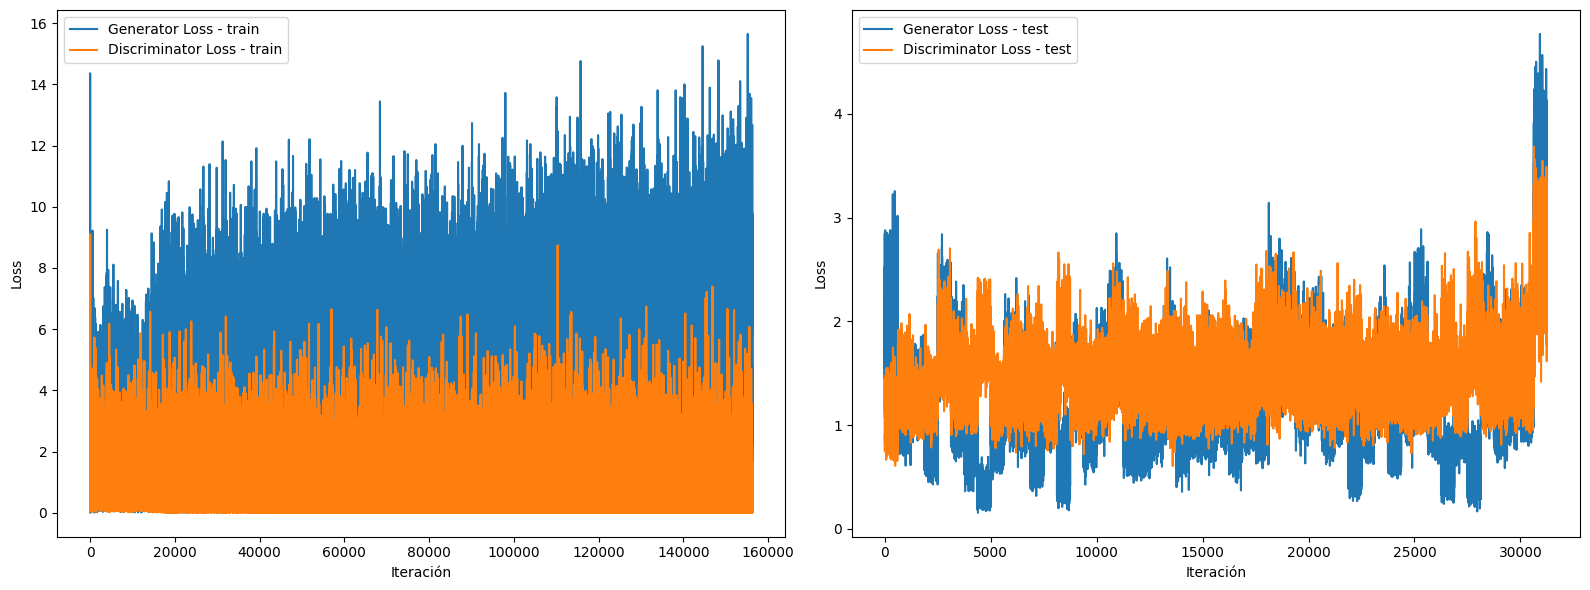

In [ ]:
data = np.load("/content/drive/MyDrive/Lembo/metricas_m3_cifar100.npz")

iteration_train = np.arange(1, len(X_train)/batch_size*epoch_count+1)
iteration_test = np.arange(1, len(X_test)/batch_size*epoch_count+1)
d_loss_itern_train = data['d_loss_itern_train']
g_loss_itern_train = data['g_loss_itern_train']
d_loss_itern_test = data['d_loss_itern_test']
g_loss_itern_test = data['g_loss_itern_test']

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
axs[0].plot(iteration_train, g_loss_itern_train, label='Generator Loss - train')
axs[0].plot(iteration_train, d_loss_itern_train, label='Discriminator Loss - train')
axs[0].set_xlabel('Iteración')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[1].plot(iteration_test, g_loss_itern_test, label='Generator Loss - test')
axs[1].plot(iteration_test, d_loss_itern_test, label='Discriminator Loss - test')
axs[1].set_xlabel('Iteración')
axs[1].set_ylabel('Loss')
axs[1].legend()
plt.tight_layout()
plt.show()

# Graficas de la pérdida para el generador y el discriminador en función de las épocas

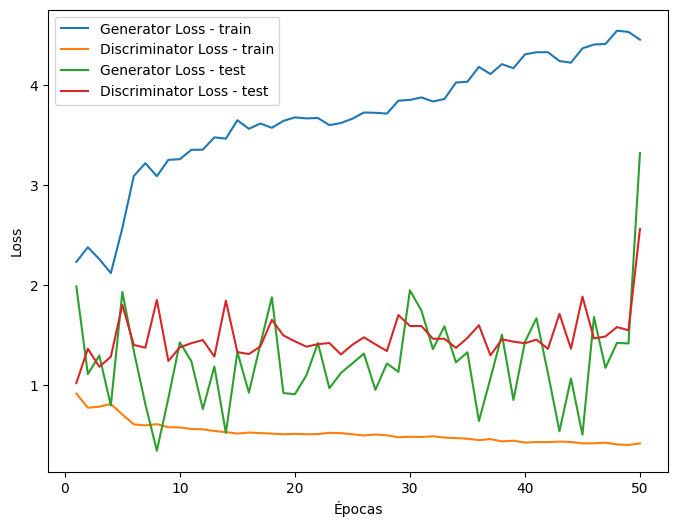

In [ ]:
data = np.load("/content/drive/MyDrive/Lembo/metricas_m3_cifar100.npz")

epochs = data['epochs']
d_loss_train = data['d_loss_train']
g_loss_train = data['g_loss_train']
d_loss_test = data['d_loss_test']
g_loss_test = data['g_loss_test']

plt.figure(figsize=(8,6))
plt.plot(epochs, g_loss_train, label='Generator Loss - train')
plt.plot(epochs, d_loss_train, label='Discriminator Loss - train')
plt.plot(epochs, g_loss_test, label='Generator Loss - test')
plt.plot(epochs, d_loss_test, label='Discriminator Loss - test')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Graficas de las métricas para el discriminador en función del número de épocas

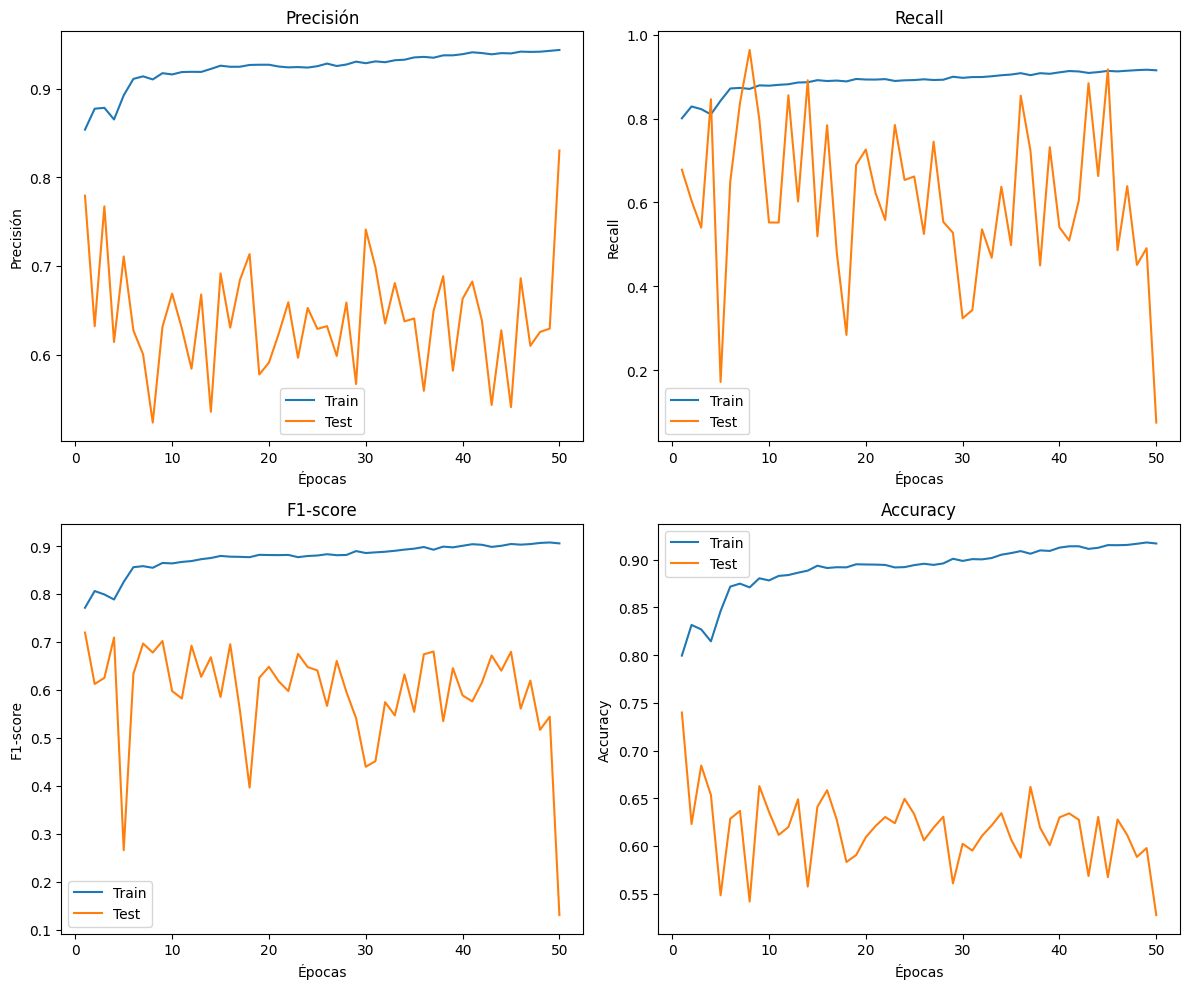

In [ ]:
data = np.load("/content/drive/MyDrive/Lembo/metricas_m3_cifar100.npz")
epochs = data['epochs']
precision_train = data['precision_train']
recall_train = data['recall_train']
f1_train = data['f1_train']
accuracy_train = data['accuracy_train']
precision_test = data['precision_test']
recall_test = data['recall_test']
f1_test = data['f1_test']
accuracy_test = data['accuracy_test']

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
epochs = np.arange(1, epoch_count + 1)
axs[0, 0].plot(epochs, precision_train, label='Train')
axs[0, 0].plot(epochs, precision_test, label='Test')
axs[0, 0].set_xlabel('Épocas')
axs[0, 0].set_ylabel('Precisión')
axs[0, 0].legend()
axs[0, 0].set_title('Precisión')
axs[0, 1].plot(epochs, recall_train, label='Train')
axs[0, 1].plot(epochs, recall_test, label='Test')
axs[0, 1].set_xlabel('Épocas')
axs[0, 1].set_ylabel('Recall')
axs[0, 1].legend()
axs[0, 1].set_title('Recall')
axs[1, 0].plot(epochs, f1_train, label='Train')
axs[1, 0].plot(epochs, f1_test, label='Test')
axs[1, 0].set_xlabel('Épocas')
axs[1, 0].set_ylabel('F1-score')
axs[1, 0].legend()
axs[1, 0].set_title('F1-score')
axs[1, 1].plot(epochs, accuracy_train, label='Train')
axs[1, 1].plot(epochs, accuracy_test, label='Test')
axs[1, 1].set_xlabel('Épocas')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].legend()
axs[1, 1].set_title('Accuracy')
plt.tight_layout()
plt.show()

# Generación de una imagen del cifar 100 pedida por el usuario

Tamaño imagen generada:  (1, 32, 32, 3)


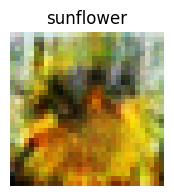

In [7]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from keras.preprocessing import image

noise_dim = 100 # Dimension del ruido

tags = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle',
    'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle',
    'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard',
    'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain',
    'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree',
    'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket',
    'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider',
    'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor',
    'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]
def get_index(word, tags_list):
    try:
        return tags_list.index(word)
    except ValueError:
        return -1  # Devuelve -1 si la palabra no se encuentra en la lista

# Cargar el modelo generador
g_model = load_model('gmodel_m3_cifar100.h5')

# Preparar la etiqueta para el número 7
imagen_a_generar = 'sunflower'
index = get_index(imagen_a_generar, tags)

#label = tf.expand_dims(numero_a_generar, axis=-1) #expando la dimension de y_train para que quede analogo al ejemplo del cifar10
label = tf.ones(1)*index

# Generar ruido aleatorio
noise = tf.random.normal(shape=(1, noise_dim))

# Generar imagen falsa
generated_image = g_model([noise, label]) #  Genero imagenes falsas
#generated_image = g_model.predict([noise, label])
print("Tamaño imagen generada: ", generated_image.shape)

plt.figure(figsize=(2,2))
img = image.array_to_img(generated_image[0], scale=True)
plt.imshow(img)
plt.axis('off')
plt.title(f"{tags[index]}")
plt.show()